In [1]:
import cv2
import pandas as pd
import numpy as np
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import spectral_clustering

%matplotlib inline

# STEP 1 : Edge Detection

In [2]:
image = cv2.imread('../File/oil_test_02.jpg')
orig = image.copy()

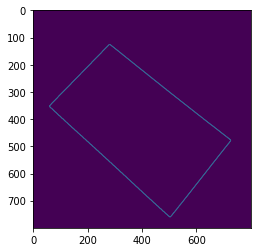

In [3]:
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
edged = cv2.Canny(blur, 70, 150)

plt.imshow(edged)

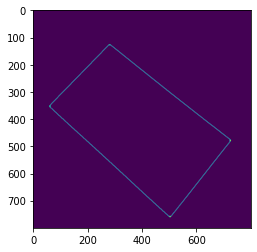

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.imshow( closed)

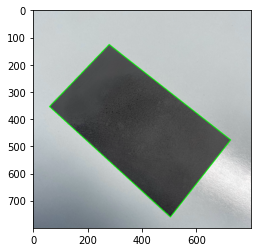

In [5]:
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:3]

for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        screenCnt = approx
        break
        
cv2.drawContours(image,[screenCnt], -1, (0,255,0), 2)

plt.imshow(image)

In [6]:
print(screenCnt)

[[[279 126]]

 [[ 60 354]]

 [[504 759]]

 [[725 476]]]


In [7]:
def order_points(pts):
    rect = np.zeros((4,2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [8]:
rect = order_points(screenCnt.reshape(4,2) / r)

(topLeft, topRight, bottomRight, bottomLeft) = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])

In [9]:
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

In [10]:
dst = np.float32([[0,0], [maxWidth-1,0], [maxWidth-1, maxHeight-1], [0,maxHeight-1]])

In [11]:
M = cv2.getPerspectiveTransform(rect, dst)

In [12]:
warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))

<ipython-input-12-c02f6d8c19e2>:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))


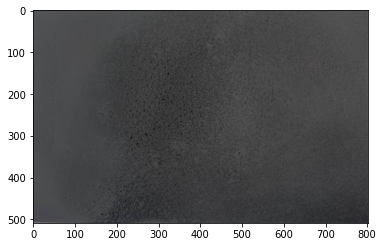

In [13]:
plt.imshow(warped)

In [14]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

In [15]:
warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

In [17]:
warped = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

In [ ]:
plt.imshow(warped)

In [ ]:
hist, bins = np.histogram(warped.ravel(), 256,[0,256])
plt.hist(warped.ravel(),256,[0,256])

In [ ]:
# cv2.imwrite('../File/04_oil_test_crop.jpg', warped)

In [ ]:
warped.shape

In [ ]:
warped.size

In [ ]:
np.count_nonzero(warped == 0)

In [ ]:
int(np.count_nonzero(warped == 0))/int(warped.size)

In [16]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(warped)

/home/mango/.local/lib/python3.8/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


HDBSCAN(gen_min_span_tree=True)

In [17]:
db = DBSCAN(eps=1, min_samples=10).fit(warped)

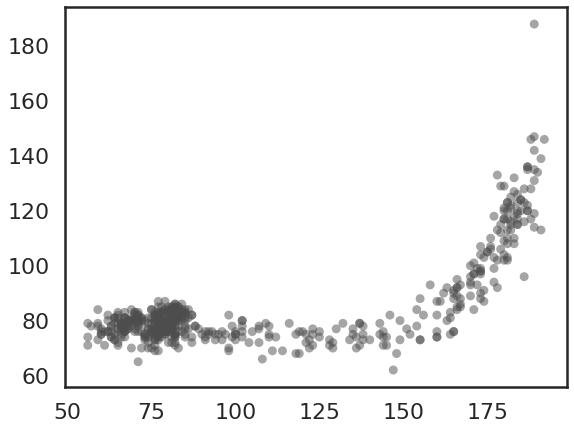

In [20]:
palette = sns.color_palette("husl", 12)
cluster_colors = [palette[col]
                  if col >= 0 else (0.3,0.3,0.3) for col in
                  db.labels_]
plt.scatter(warped.T[0], warped.T[1], c=cluster_colors, **plot_kwds)

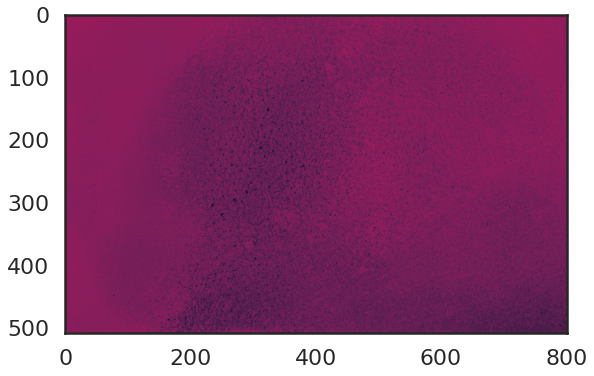

In [21]:
plt.imshow(warped)

In [18]:
warped

array([[255, 255,   0, ..., 255, 255, 255],
       [255, 255,   0, ...,   0,   0,   0],
       [255, 255,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [19]:
db = pd.DataFrame(warped)

In [20]:
db

0    1    2    3    4    5    6    7    8    9    ...  792  793  794  \
0    255  255    0    0    0    0    0    0    0    0  ...  255  255  255   
1    255  255    0    0    0    0    0    0    0  255  ...    0    0    0   
2    255  255    0    0    0    0    0    0    0    0  ...    0    0    0   
3    255  255    0    0    0    0    0    0    0    0  ...    0    0    0   
4    255  255    0    0    0    0    0    0    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
504    0    0    0    0    0    0    0    0    0    0  ...  255  255  255   
505    0    0    0    0    0    0    0    0    0    0  ...  255  255  255   
506    0    0    0    0    0    0    0    0    0    0  ...  255  255  255   
507    0    0    0    0    0    0    0    0    0    0  ...  255  255  255   
508  255  255  255  255  255  255  255  255  255  255  ...  255  255  255   

     795  796  797  798  799  800  801  
0    255  255  255  255  255  255  255  
1      0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0  
3      0    0    0    0    0    0    0  
4      0    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
504  255  255  255  255  255  255    0  
505  255  255  255  255  255  255  255  
506  255  255  255  255  255  255  255  
507  255  255  255  255  255  255  255  
508  255  255  255  255  255  255  255  

[509 rows x 802 columns]

In [21]:
scaler = StandardScaler()

In [22]:
X_scaled = scaler.fit_transform(db) 

In [24]:
from sklearn.preprocessing import normalize 
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

In [26]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
print(X_principal.head()) 

         P1        P2
0 -0.486990  0.007840
1  0.572807  0.165562
2  0.819501  0.596427
3  0.826206  0.584501
4  0.821799  0.589559


In [27]:
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal) 
labels = db_default.labels_ 

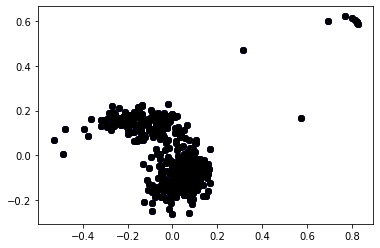

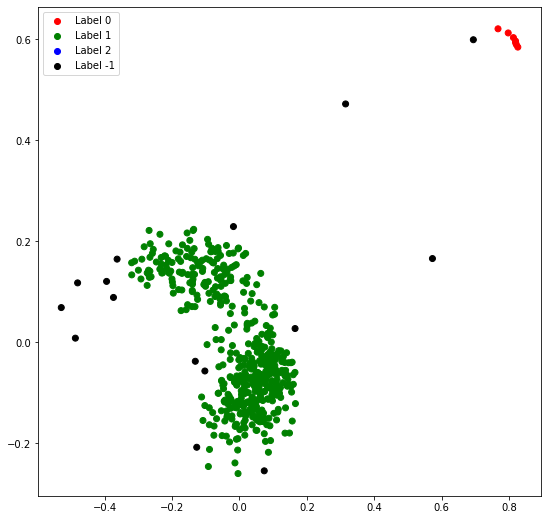

In [28]:
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r'); 
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g'); 
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b'); 
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k'); 
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 

In [29]:
db = DBSCAN(eps = 0.0375, min_samples = 50).fit(X_principal) 
labels1 = db.labels_ 

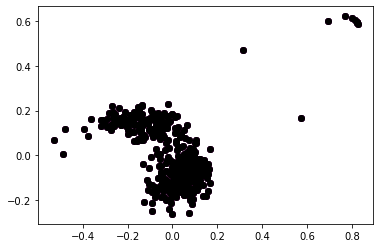

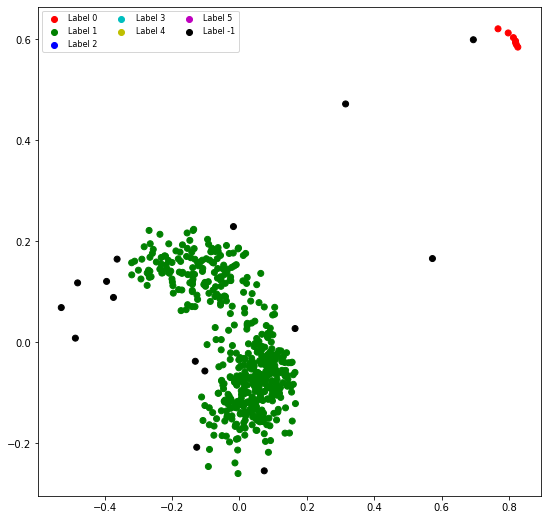

In [31]:
colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'
  
cvec = [colours1[label] for label in labels] 
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ] 
  
r = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[0]) 
g = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[1]) 
b = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[2]) 
c = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[3]) 
y = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[4]) 
m = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[5]) 
k = plt.scatter( 
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[6]) 
  
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
plt.legend((r, g, b, c, y, m, k), 
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 
            'Label 5', 'Label -1'), 
           scatterpoints = 1, 
           loc ='upper left', 
           ncol = 3, 
           fontsize = 8) 
plt.show() 

In [34]:
from sklearn import datasets

iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

Sepal length  Sepal width  Petal length  Petal width  labels
0           5.1          3.5           1.4          0.2       0
1           4.9          3.0           1.4          0.2       0
2           4.7          3.2           1.3          0.2       0
3           4.6          3.1           1.5          0.2       0
4           5.0          3.6           1.4          0.2       0

In [35]:
feature = data[ ['Sepal length','Sepal width','Petal length','Petal width']]
feature.head()

Sepal length  Sepal width  Petal length  Petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

In [36]:
model = DBSCAN(min_samples=6)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

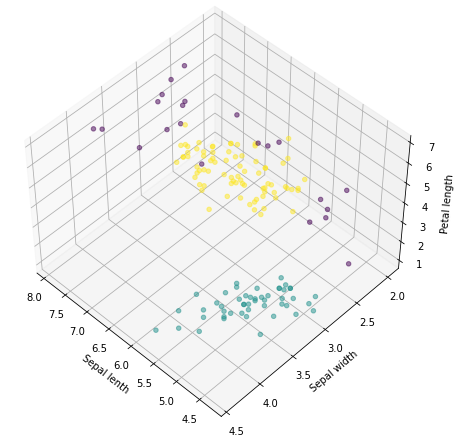

In [37]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Sepal length'],r['Sepal width'],r['Petal length'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Sepal lenth')
ax.set_ylabel('Sepal width')
ax.set_zlabel('Petal length')
plt.show()